In [2]:
!pip install --upgrade nltk gensim==3.8.0 bokeh

In [4]:
from gensim.models import Word2Vec
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import tensorflow_datasets as tfds
import tensorflow as tf
import nltk
import numpy as np
import functools
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

np.random.seed(42)
nltk.download('wordnet')
nltk.download('stopwords')

plt.style.use('dark_background')
matplotlib.rcParams['figure.figsize'] = (16, 9)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def get_train_test_results(df_train, df_test, delete_punct = True, lemmatize = True, skip_numbers = True, remove_stop_words = True, min_count = 5, drop_alpha = 0.0, window = 5, size = 300):
    def tokenize_row(row):
        custom_sw = set(['wa', 'doe', 'ha'])
        tokenizer = WordPunctTokenizer()
        result = tokenizer.tokenize(row.decode("utf-8").lower())
        if delete_punct:
            tokenizer_words = RegexpTokenizer(r'\w+')
            if skip_numbers:
                tokenizer_words = RegexpTokenizer(r'[a-z]+')
            result = tokenizer_words.tokenize(' '.join(result))
        if lemmatize:
            lemmatizer = WordNetLemmatizer()
            result = [lemmatizer.lemmatize(tok) for tok in result]
        if remove_stop_words:
            stop_words = set(stopwords.words('english'))
            result = [x for x in result if x not in stop_words]
            result = [x for x in result if x not in custom_sw]
        return result

    def exlude_most_friq(data_tokenized):
        if drop_alpha == 0.0:
            return data_tokenized
        all_tokens = []
        for row in data_tokenized:
            all_tokens += [tok for tok in row]
        all_tokens = np.array(all_tokens)
        dictionary, counts = np.unique(all_tokens, return_counts=True)
        sorted_tokens = sorted(list(zip(dictionary, counts)), key=functools.cmp_to_key(lambda tok1, tok2: tok2[1] - tok1[1]))
        drop = int(len(sorted_tokens) * drop_alpha)
        print("Words to drop:", drop)
        exclude_list = set([tok[0] for tok in sorted_tokens[:drop]])
        print("Excluded by alpha words:", exclude_list)
        def exclude(row):
            return [x for x in row if x not in exclude_list]
        return [exclude(row) for row in data_tokenized]

    def create_w2v_model(df):
        data_tokenized = [tokenize_row(row) for row in df['text']]
        assert isinstance(data_tokenized, list)
        assert all(isinstance(row, list) for row in data_tokenized)
        assert all(all(isinstance(tok, str) for tok in row) for row in data_tokenized)
        assert not delete_punct or not skip_numbers or all(all(tok.islower() for tok in row) for row in data_tokenized)

        data_tokenized = exlude_most_friq(data_tokenized)
        model = Word2Vec(data_tokenized, 
                        size=size,
                        min_count=min_count,
                        window=window).wv

        return model

    model = create_w2v_model(tfds.as_dataframe(ds))
    print("Vocab size:", len(model.vocab))

    def get_phrase_embedding(model, phrase):
        tokenized = tokenize_row(phrase)
        vectors = []
        for token in tokenized:
            try:
                vectors.append(model.get_vector(token))
            except KeyError:
                pass
        if len(vectors) == 0:
            return np.zeros(size)
        return np.average(vectors, axis = 0)

    def append_embedings(data_frame):
        res = get_phrase_embedding(model, b'What two hello European countries are joined by the Gran San Bernardo Pass?')
        assert res.shape[0] == size

        embedings = [get_phrase_embedding(model, row) for row in data_frame['text']]

        data_frame['embedings'] = embedings
        import pandas as pd
        return pd.concat([data_frame['label-coarse'], data_frame['embedings'].apply(pd.Series)], axis = 1)

    df_train = append_embedings(df)
    df_test = append_embedings(df_test)

    return df_train, df_test

In [6]:
def get_input_cols(df):
    emb = list(df.columns)
    emb.remove('label-coarse')
    return emb

def benchmark_embedings(df_train, df_test):
    from sklearn import svm
    emb = get_input_cols(df_train)
    clf = svm.SVC().fit(df_train[emb], df_train['label-coarse'])
    acc = clf.score(df_test[emb], df_test['label-coarse'])
    print("Accuracy:", acc)
    return acc


In [7]:
builder = tfds.builder('trec')
builder.download_and_prepare()
ds = builder.as_dataset(split='train', shuffle_files=True)
ds_test = builder.as_dataset(split='test', shuffle_files=True)

### Dataset exploring


In [126]:
df = tfds.as_dataframe(ds)
df.head()

,label-coarse,label-fine,text
0,3,4,b'Who was Camp David named for ?'
1,0,7,b'What is the C programming language ?'
2,5,14,b'Where is the oldest living thing on earth ?'
3,4,13,b'How many claws has a lobster called a pistol...
4,3,4,"b""What son of a 15-year-old Mexican girl and a..."


Датасет представляет собой список вопросов, классифицированных по типу

In [6]:
df.describe()

,label-coarse,label-fine
count,5452.000000,5452.000000
mean,2.356933,11.665077
std,1.793065,9.231112
min,0.000000,0.000000
25%,1.000000,4.000000
50%,3.000000,10.000000
75%,4.000000,14.000000
max,5.000000,46.000000


Есть два типа классов, я буду классифицировать на 6 классов

In [9]:
hist = df['label-coarse'].value_counts().to_frame()
classes = hist.index
hist

,label-coarse
1,1250
3,1223
0,1162
4,896
5,835
2,86


Text(0.5, 0, 'Classes')

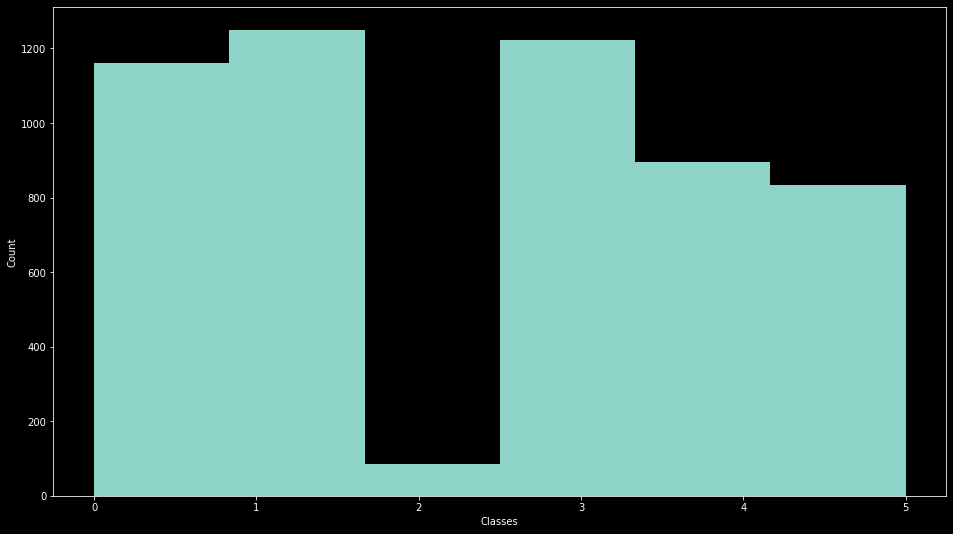

In [10]:
plt.hist(df['label-coarse'], bins=len(classes))
plt.ylabel('Count')
plt.xlabel('Classes')

Как видно данные не сбалансированы

In [12]:
from sklearn.utils import resample
import pandas as pd
balansed = []
target = hist['label-coarse'][hist.index[0]]
print(target)
for cls in hist.index:
    if hist['label-coarse'][cls] >= target:
        balansed.append(df[df['label-coarse'] == cls])
        continue
    balansed.append(resample(df[df['label-coarse'] == cls], 
                                 replace=True,     
                                 n_samples=target,    
                                 random_state=42))
    balansed[-1].drop(['label-coarse'], axis=1)
df = pd.concat(balansed)
df

1250


,label-coarse,label-fine,text
10,1,14,"b""What is November 's birthstone ?"""
11,1,23,b'What is a fear of reptiles ?'
23,1,23,b'What is a fear of fish ?'
29,1,26,"b""What product 's ads claim that it `` elimina..."
37,1,10,b'What age followed the Bronze Age ?'
...,...,...,...
2357,2,3,b'What does BTU mean ?'
444,2,34,b'What is the acronym for the National Bureau ...
3196,2,34,"b""What 's the abbreviation for limited partner..."
4545,2,3,"b""What does `` B.Y.O.B. '' mean ?"""


Уровнял по типу класс

In [13]:
df['label-coarse'].value_counts()

3    1250
2    1250
5    1250
1    1250
4    1250
0    1250
Name: label-coarse, dtype: int64

In [16]:
df_train, df_test = get_train_test_results(df, tfds.as_dataframe(ds_test), lemmatize=False, min_count= 5, window= 1, size=400)
acc = benchmark_embedings(df_train, df_test)

Vocab size: 1108
Accuracy: 0.676


In [18]:
df = tfds.as_dataframe(ds)
df_train, df_test = get_train_test_results(df, tfds.as_dataframe(ds_test), lemmatize=False, min_count= 5, window= 1, size=400)
acc = benchmark_embedings(df_train, df_test)

Vocab size: 1108
Accuracy: 0.7


In [131]:
for t in df[df['label-coarse'] == 0].sample(5)['text']:
    print(t)

b'What should you do for an ankle sprain ?'
b"What is meant by `` capital market '' ?"
b'What is the origin of the word trigonometry ?'
b"Why is the universe flat , if it started by an explosion , shouldn 't it be a sphere ?"
b"What 's the staff of life mentioned in the Lord 's Prayer ?"


In [130]:
for t in df[df['label-coarse'] == 1].sample(5)['text']:
    print(t)

b"What are some important events of the 1830 's ?"
b'What tragedy befell the city of Dogtown in 1899 ?'
b'Which airplane was Fawaz Younis convicted of hijacking ?'
b'Name the Islamic counterpart to the Red Cross .'
b'What is a fear of rejection ?'


In [132]:
for t in df[df['label-coarse'] == 2].sample(5)['text']:
    print(t)

b'What is the abbreviation of the International Olympic Committee ?'
b'What does VCR stand for ?'
b'What is DEET ?'
b"What does INRI stand for when used on Jesus ' cross ?"
b'What does BUD stand for ?'


In [133]:
for t in df[df['label-coarse'] == 3].sample(5)['text']:
    print(t)

b'What multitalented Academy-award-winning director failed a college course in motion-picture production ?'
b'What was the name of the Confederate mounted guerrilla group with which Jesse James and Coleman Younger had ridden ?'
b'What English explorer discovered and named Virginia ?'
b'Who is considered The First Lady of the American Stage ?'
b"What are Arnold Palmer 's fans called ?"


In [134]:
for t in df[df['label-coarse'] == 4].sample(5)['text']:
    print(t)

b'About how many Americans are still unaccounted for from the Vietnam war ?'
b'In what year was De Gaulle elected president of France ?'
b'How many colors are there in the spectrum ?'
b'How many referees work a soccer game ?'
b'How long does it take for your blood to make one complete trip through the body ?'


In [135]:
for t in df[df['label-coarse'] == 5].sample(5)['text']:
    print(t)

b'Where are the leading medical groups specializing in lung diseases ?'
b'What web sites are linked to the Report on Genesis Eldercare ?'
b'What is the name of the gulf between Sweden and Finland ?'
b'Where must a soccer goalie stand to be permitted to handle the ball ?'
b'What Caribbean island is northeast of Trinidad ?'


Некоторые классы очевидны, например последний явно географические вопросы, но придумать с ходу какую-либо фичу для них не просто

Балансировка для SVM приводит к худшим результатам, поэтому буду работать с оригинальным датасетом

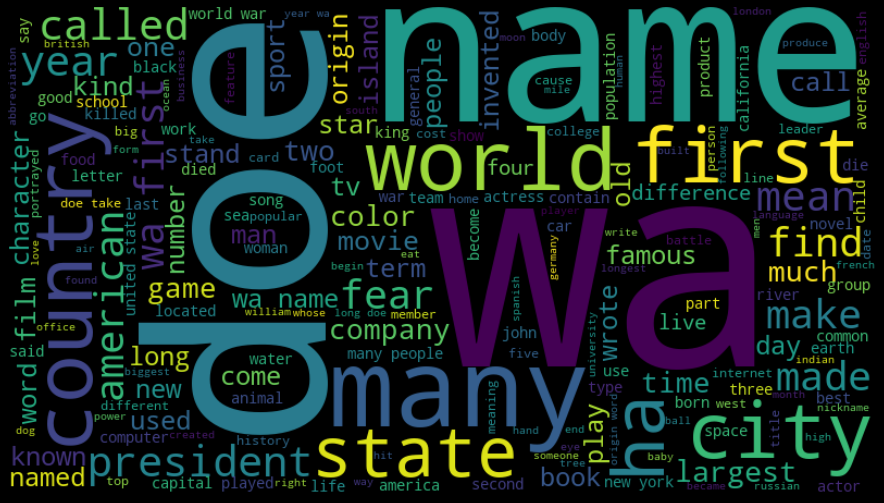

In [19]:
def normalize_row(row):
    tokenizer = WordPunctTokenizer()
    result = tokenizer.tokenize(row.decode("utf-8").lower())
    tokenizer_words = RegexpTokenizer(r'\w+')
    result = tokenizer_words.tokenize(' '.join(result))
    lemmatizer = WordNetLemmatizer()
    result = [lemmatizer.lemmatize(tok) for tok in result]
    stop_words = set(stopwords.words('english'))
    result = [x for x in result if x not in stop_words]
    return " ".join(result)

df = tfds.as_dataframe(ds)
rows = [normalize_row(text) for text in df['text']]
wordcloud = WordCloud(width = 800, height = 450).generate(" ".join(rows))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Видно, что есть несколько мусорных слов, можно добавить их в список стоп слов

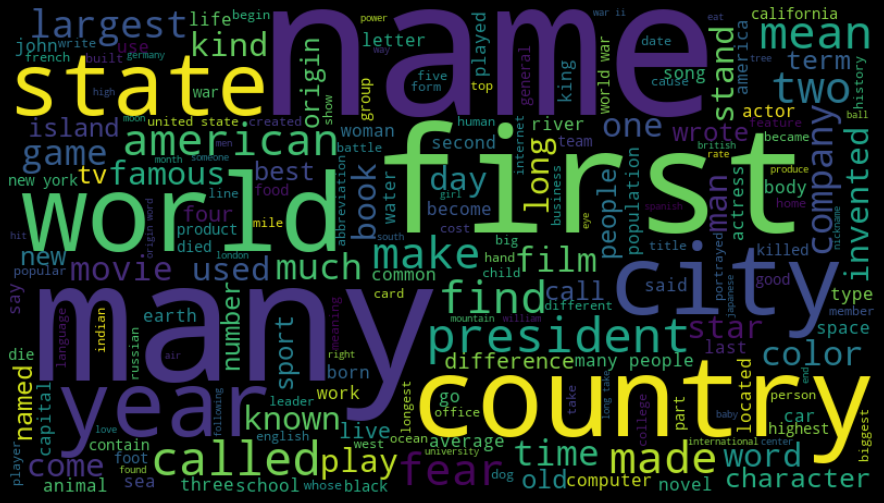

In [20]:
custom_sw = set(['wa', 'doe', 'ha'])
def normalize_row(row):
    tokenizer = WordPunctTokenizer()
    result = tokenizer.tokenize(row.decode("utf-8").lower())
    tokenizer_words = RegexpTokenizer(r'\w+')
    result = tokenizer_words.tokenize(' '.join(result))
    lemmatizer = WordNetLemmatizer()
    result = [lemmatizer.lemmatize(tok) for tok in result]
    stop_words = set(stopwords.words('english'))
    result = [x for x in result if x not in stop_words]
    result = [x for x in result if x not in custom_sw]
    return " ".join(result)

df = tfds.as_dataframe(ds)
rows = [normalize_row(text) for text in df['text']]
wordcloud = WordCloud(width = 800, height = 450).generate(" ".join(rows))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Baseline model different processing tests

In [37]:
toggle_values = [
     {'delete_punct' : False, 'lemmatize' : False, 'skip_numbers' : False, 'remove_stop_words' : False},       
     {'delete_punct' : False, 'lemmatize' : True, 'skip_numbers' : True, 'remove_stop_words' : True},       
     {'delete_punct' : True, 'lemmatize' : False, 'skip_numbers' : True, 'remove_stop_words' : True},       
     {'delete_punct' : True, 'lemmatize' : True, 'skip_numbers' : False, 'remove_stop_words' : True},       
     {'delete_punct' : True, 'lemmatize' : True, 'skip_numbers' : True, 'remove_stop_words' : False},       
     {'delete_punct' : True, 'lemmatize' : True, 'skip_numbers' : True, 'remove_stop_words' : True},       
]
min_counts = [1, 2, 3, 4, 5]
alpha_drops = [0.0, 0.001, 0.005, 0.01, 0.02]
windows    = [1, 2, 3, 4, 5]
sizes      = [50, 100, 200, 300, 400, 500]

попробуем разные параметры для генерации эмбедингов

In [22]:
best_toggles = {}
best_acc = 0
for toggles in toggle_values[:]:
    print("Running for:", toggles)
    df_train, df_test = get_train_test_results(tfds.as_dataframe(ds), tfds.as_dataframe(ds_test), toggles['delete_punct'], toggles['lemmatize'], toggles['skip_numbers'], toggles['remove_stop_words'])
    acc = benchmark_embedings(df_train, df_test)
    if acc < best_acc:
        continue
    best_acc = acc
    best_toggles = toggles
print("Best:", best_toggles)

Running for: {'delete_punct': True, 'lemmatize': True, 'skip_numbers': True, 'remove_stop_words': True}


Vocab size: 1131
Accuracy: 0.642
Running for: {'delete_punct': False, 'lemmatize': True, 'skip_numbers': True, 'remove_stop_words': True}


Vocab size: 1176
Accuracy: 0.38
Running for: {'delete_punct': True, 'lemmatize': False, 'skip_numbers': True, 'remove_stop_words': True}


Vocab size: 1108
Accuracy: 0.672
Running for: {'delete_punct': True, 'lemmatize': True, 'skip_numbers': False, 'remove_stop_words': True}


Vocab size: 1163
Accuracy: 0.638
Running for: {'delete_punct': True, 'lemmatize': True, 'skip_numbers': True, 'remove_stop_words': False}


Vocab size: 1237
Accuracy: 0.384
Best: {'delete_punct': True, 'lemmatize': False, 'skip_numbers': True, 'remove_stop_words': True}


видно, что лемантизация портит результат, остальные способы вроде бы помогают

In [8]:
best_window = 0
best_acc = 0
for window in windows[:]:
    print("Running for:", window)
    df_train, df_test = get_train_test_results(tfds.as_dataframe(ds), tfds.as_dataframe(ds_test), lemmatize=False, window=window)
    acc = benchmark_embedings(df_train, df_test)
    if acc < best_acc:
        continue
    best_acc = acc
    best_window = window
print("Best:", best_window)

Running for: 1


Vocab size: 1108
Accuracy: 0.698
Running for: 2


Vocab size: 1108
Accuracy: 0.706
Running for: 3


Vocab size: 1108
Accuracy: 0.688
Running for: 4


Vocab size: 1108
Accuracy: 0.684
Running for: 5


Vocab size: 1108
Accuracy: 0.682
Best: 2


наилучший результат с маленькими окнами, видимо потому что вопросы в большинстве своем короткие

In [ ]:
best_mc = 0
best_acc = 0
for mc in min_counts[:]:
    print("Running for:", mc)
    df_train, df_test = get_train_test_results(tfds.as_dataframe(ds), tfds.as_dataframe(ds_test), lemmatize=False, min_count=mc, window=best_window)
    acc = benchmark_embedings(df_train, df_test)
    if acc < best_acc:
        continue
    best_acc = acc
    best_mc = mc
print("Best:", best_mc)

Running for: 1


Vocab size: 8040
Accuracy: 0.478
Running for: 2


Vocab size: 3260
Accuracy: 0.688
Running for: 3


Vocab size: 2029
Accuracy: 0.698
Running for: 4


Vocab size: 1446
Accuracy: 0.708
Running for: 5


Vocab size: 1108
Accuracy: 0.714
Best: 5


отбрасывание правого хвоста улучшает результат

In [ ]:
best_a = 0
best_acc = 0
for a in alpha_drops[:]:
    print("Running for:", a)
    df_train, df_test = get_train_test_results(tfds.as_dataframe(ds), tfds.as_dataframe(ds_test), best_toggles['delete_punct'], best_toggles['lemmatize'], best_toggles['skip_numbers'], best_toggles['remove_stop_words'], drop_alpha=a, min_count=best_mc, window=best_window)
    acc = benchmark_embedings(df_train, df_test)
    if acc < best_acc:
        continue
    best_acc = acc
    best_a = a
print("Best:", best_a)

Running for: 0.0


Vocab size: 1108
Accuracy: 0.714
Running for: 0.001
Words to drop: 8
Excluded by alpha words: {'first', 'name', 'world', 'country', 'many', 'people', 'city', 'u'}


Vocab size: 1100
Accuracy: 0.692
Running for: 0.005
Words to drop: 40
Excluded by alpha words: {'year', 'president', 'film', 'best', 'company', 'find', 'american', 'mean', 'much', 'two', 'many', 'people', 'get', 'war', 'take', 'name', 'u', 'famous', 'fear', 'tv', 'first', 'origin', 'long', 'largest', 'used', 'city', 'game', 'state', 'new', 'made', 'called', 'one', 'word', 'movie', 'country', 'world', 'day', 'kind', 'known', 'make'}


Vocab size: 1068
Accuracy: 0.596
Running for: 0.01
Words to drop: 80
Excluded by alpha words: {'last', 'character', 'team', 'famous', 'wrote', 'fear', 'first', 'long', 'show', 'game', 'city', 'call', 'new', 'called', 'country', 'john', 'information', 'novel', 'president', 'company', 'much', 'named', 'come', 'man', 'name', 'u', 'tv', 'origin', 'number', 'king', 'color', 'state', 'one', 'book', 'world', 'known', 'use', 'make', 'year', 'four', 'river', 'film', 'best', 'find', 'played', 'mean', 'two', 'people', 'get', 'baseball', 'term', 'countries', 'born', 'english', 'star', 'word', 'movie', 'died', 'kind', 'states', 'play', 'old', 'difference', 'american', 'home', 'south', 'many', 'time', 'stand', 'war', 'take', 'three', 'highest', 'invented', 'largest', 'used', 'made', 'america', 'live', 'day'}


Vocab size: 1028
Accuracy: 0.536
Running for: 0.02
Words to drop: 160
Excluded by alpha words: {'last', 'character', 'food', 'cities', 'charles', 'five', 'us', 'california', 'school', 'different', 'team', 'woman', 'population', 'good', 'portrayed', 'language', 'famous', 'said', 'song', 'wrote', 'fear', 'killed', 'first', 'long', 'show', 'game', 'city', 'dog', 'call', 'top', 'university', 'makes', 'new', 'called', 'water', 'country', 'work', 'john', 'information', 'years', 'national', 'novel', 'president', 'way', 'company', 'popular', 'much', 'general', 'named', 'black', 'come', 'become', 'man', 'law', 'name', 'u', 'united', 'tv', 'origin', 'york', 'number', 'longest', 'sea', 'king', 'color', 'state', 'body', 'big', 'internet', 'th', 'one', 'book', 'person', 'world', 'actress', 'sport', 'line', 'go', 'known', 'use', 'make', 'year', 'four', 'river', 'earth', 'die', 'computer', 'film', 'best', 'red', 'find', 'played', 'mean', 'title', 'say', 'two', 'people', 'drink', 'car', 'get', 'baseba

Vocab size: 948
Accuracy: 0.464
Best: 0.0


отбрасывание левого хвоста ухудшает результат, тк наиболее частые слова выкинулись со стоп словами

In [ ]:
best_sz = 0
best_acc = 0
for sz in sizes[:]:
    print("Running for:", sz)
    df_train, df_test = get_train_test_results(tfds.as_dataframe(ds), tfds.as_dataframe(ds_test), best_toggles['delete_punct'], best_toggles['lemmatize'], best_toggles['skip_numbers'], best_toggles['remove_stop_words'], size = sz, min_count=best_mc, window=best_window)
    acc = benchmark_embedings(df_train, df_test)
    if acc < best_acc:
        continue
    best_acc = acc
    best_sz = sz
print("Best:", best_sz)

Running for: 400


Vocab size: 1108
Accuracy: 0.726
Running for: 500


Vocab size: 1108
Accuracy: 0.724
Best: 400


In [ ]:
print(best_toggles, best_mc, best_window, best_a, best_sz)

{'delete_punct': True, 'lemmatize': False, 'skip_numbers': True, 'remove_stop_words': True} 5 1 300 400


размер эмбединга 400 лучший

### One hot embedings attempt


In [60]:
from sklearn.preprocessing import OneHotEncoder
custom_sw = set(['wa', 'doe', 'ha'])
def normalize_row(row):
    tokenizer = WordPunctTokenizer()
    result = tokenizer.tokenize(row.decode("utf-8").lower())
    tokenizer_words = RegexpTokenizer(r'[a-z]+')
    result = tokenizer_words.tokenize(' '.join(result))
    lemmatizer = WordNetLemmatizer()
    result = [lemmatizer.lemmatize(tok) for tok in result]
    stop_words = set(stopwords.words('english'))
    result = [x for x in result if x not in stop_words]
    result = [x for x in result if x not in custom_sw]
    return result

def align_row(row, length):
    while len(row) < length:
        row.append('<UNK>')
    return row

def prepare_df(df, ml = 0):
    rows = [normalize_row(text) for text in df['text']]
    max_len = max(ml, len(max(rows, key=len)))
    rows = [align_row(r, max_len) for r in rows]
    return rows

df_train = prepare_df(tfds.as_dataframe(ds))
enc = OneHotEncoder(handle_unknown='ignore').fit(df_train)
print(len(enc.categories_))

df_test = prepare_df(tfds.as_dataframe(ds_test), len(enc.categories_))

df_train = enc.transform(df_train)
df_test = enc.transform(df_test)
print(df_train.shape, df_test.shape)

18
(5452, 13919) (500, 13919)


In [61]:
df_train = pd.DataFrame(df_train.todense())
df_train['label-coarse'] = tfds.as_dataframe(ds)['label-coarse']
df_test = pd.DataFrame(df_test.todense())
df_test['label-coarse'] = tfds.as_dataframe(ds_test)['label-coarse']

In [65]:
from sklearn.neural_network import MLPClassifier
emb = get_input_cols(df_train)
clf = MLPClassifier(random_state=42, max_iter=300, hidden_layer_sizes=(1024, 512)).fit(df_train[emb], df_train['label-coarse'])
acc = clf.score(df_test[emb], df_test['label-coarse'])

In [66]:
acc

0.762

Попытка закодировать ван хот дает хороший результат, но требует много времени для обуччения

## ML models


### knn


In [55]:
from sklearn.neighbors import KNeighborsClassifier
nn_count = [1, 3, 5, 8, 13, 15, 18, 21, 35, 50]
df_train, df_test = get_train_test_results(tfds.as_dataframe(ds), tfds.as_dataframe(ds_test), lemmatize=False, min_count= 5, window= 1, size=400)
emb = get_input_cols(df_train)
accuracies = []
for cnt in nn_count:
    neigh = KNeighborsClassifier(n_neighbors=cnt)
    neigh.fit(df_train[emb], df_train['label-coarse'])
    accuracies.append(neigh.score(df_test[emb], df_test['label-coarse']))
    print(accuracies[-1])
accuracies

Vocab size: 1108
0.41
0.648
0.452
0.652
0.654
0.642
0.63
0.622
0.606
0.57


[0.41, 0.648, 0.452, 0.652, 0.654, 0.642, 0.63, 0.622, 0.606, 0.57]

Text(0.5, 0, 'NN count')

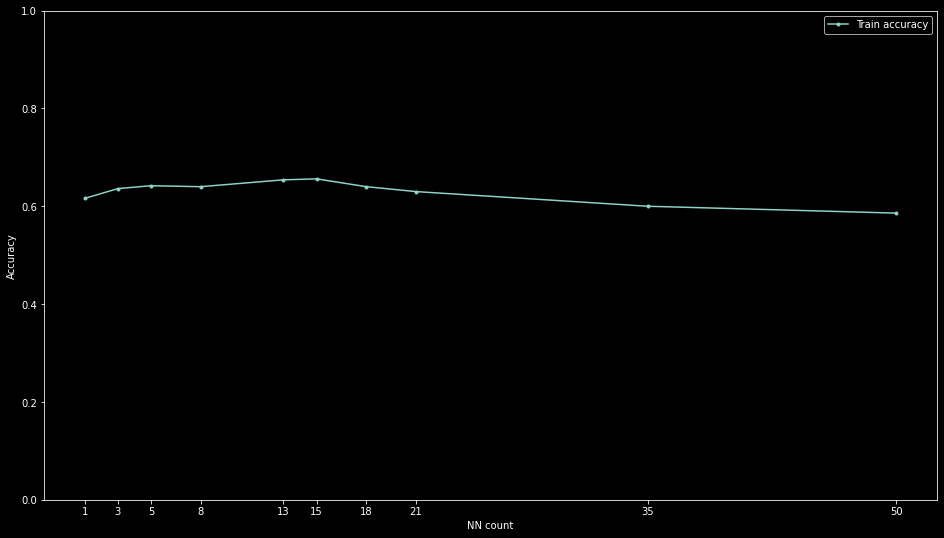

In [77]:
plt.plot(nn_count, accuracies, marker='.', ls = '-',  label='Train accuracy')
plt.xticks(nn_count)
plt.legend()
plt.ylim((0,1))
plt.ylabel('Accuracy')
plt.xlabel('NN count')

Ближайшие соседи уступают бейзлайну в виде свм и дают 65проц

### Gradient Boosting

In [81]:
from sklearn.ensemble import GradientBoostingClassifier
n_cnts = [50, 100, 200, 300, 500]
depths = [1, 2]
df_train, df_test = get_train_test_results(tfds.as_dataframe(ds), tfds.as_dataframe(ds_test), lemmatize=False, min_count= 5, window= 1, size=400)
emb = get_input_cols(df_train)
n_accuracies = []
for n in n_cnts:
    clf = GradientBoostingClassifier(n_estimators=n, learning_rate=1.0, max_depth=1, random_state=42)
    clf.fit(df_train[emb], df_train['label-coarse'])
    n_accuracies.append(clf.score(df_test[emb], df_test['label-coarse']))
    print(n_accuracies[-1])
n_accuracies

Vocab size: 1108
0.62
0.626
0.65
0.664
0.656


[0.62, 0.626, 0.65, 0.664, 0.656]

In [85]:
lrs = [0.1, 1.5, 2.0, 10.0]
lr_accuracies = []
for lr in lrs:
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=lr, max_depth=1, random_state=42)
    clf.fit(df_train[emb], df_train['label-coarse'])
    lr_accuracies.append(clf.score(df_test[emb], df_test['label-coarse']))
    print(lr_accuracies[-1])
lr_accuracies

0.57
0.588
0.22
0.152


[0.57, 0.588, 0.22, 0.152]

In [86]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.6, max_depth=2, random_state=42)
clf.fit(df_train[emb], df_train['label-coarse'])
lr_accuracies.append(clf.score(df_test[emb], df_test['label-coarse']))
print(lr_accuracies[-1])

0.072


Text(0.5, 0, 'Estimators count')

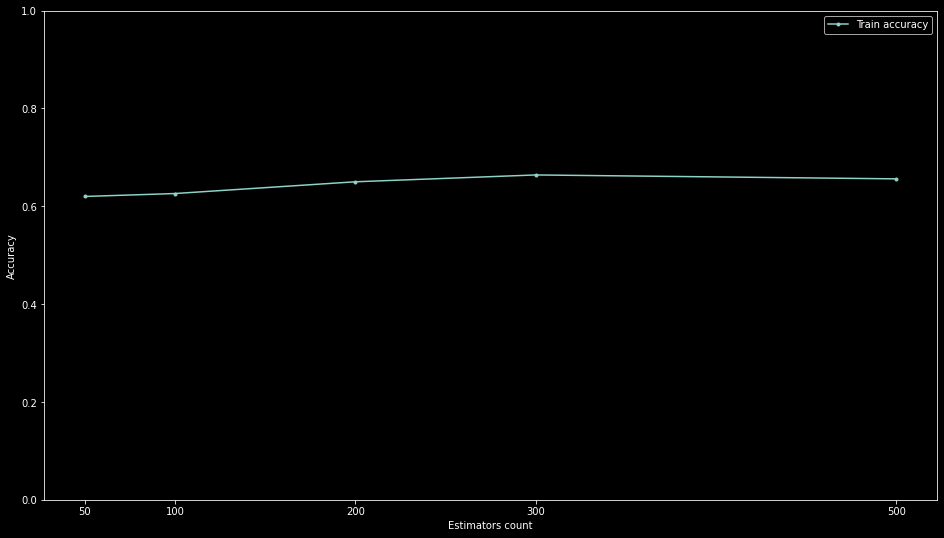

In [87]:
plt.plot(n_cnts, n_accuracies, marker='.', ls = '-',  label='Train accuracy')
plt.xticks(n_cnts)
plt.legend()
plt.ylim((0,1))
plt.ylabel('Accuracy')
plt.xlabel('Estimators count')

Аналогично с градиентным бустингом, возможно причина в том что эмбединги оптимизировались для другой модели

## NN models

### MLP baseline

In [71]:
df_train, df_test = get_train_test_results(tfds.as_dataframe(ds), tfds.as_dataframe(ds_test), lemmatize=False, min_count= 5, window= 1, size=400)
emb = get_input_cols(df_train)

Vocab size: 1108


In [72]:
df_train, df_test = get_train_test_results(tfds.as_dataframe(ds), tfds.as_dataframe(ds_test), lemmatize=False, min_count= 5, window= 1, size=400)
emb = get_input_cols(df_train)

x_train = df_train[emb].to_numpy()
x_test = df_test[emb].to_numpy()

y_train = df_train['label-coarse'].to_numpy()
y_test = df_test['label-coarse'].to_numpy()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [73]:
x_train.shape, x_test.shape

((5452, 400), (500, 400))

In [74]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=300).fit(x_train, y_train)
clf.score(x_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.666

Обычный персептрой дает 66проц, как и ML алгоритмы

### CNN

In [88]:
def normalize_row(row):
    custom_sw = set(['wa', 'doe', 'ha'])
    tokenizer = WordPunctTokenizer()
    result = tokenizer.tokenize(row.decode("utf-8").lower())
    tokenizer_words = RegexpTokenizer(r'[a-z]+')
    result = tokenizer_words.tokenize(' '.join(result))
    stop_words = set(stopwords.words('english'))
    result = [x for x in result if x not in stop_words]
    result = [x for x in result if x not in custom_sw]
    return result

max_length = 18
df = tfds.as_dataframe(ds)
data_tokenized = [normalize_row(r) for r in df['text']]

model_w2v = Word2Vec(data_tokenized, 
                 size=300,
                 min_count=1,
                 window=5, iter=100).wv

pretrained_weights = model_w2v.wv.syn0
vocab_size, emdedding_size = pretrained_weights.shape

def word2idx(word):
    try:
        return model_w2v.wv.vocab[word].index
    except KeyError:
        return 0
def idx2word(idx):
    return model_w2v.wv.index2word[idx]

def get_df(data):
    res = np.zeros([len(data), max_length], dtype=np.int32)
    for i, sentence in enumerate(data):
        for t, word in enumerate(sentence[:-1]):
            res[i, t] = word2idx(word)
    return res

df_test = tfds.as_dataframe(ds_test)

train_x = get_df(data_tokenized)
test_x = get_df([normalize_row(r) for r in df_test['text']])

train_y = tf.keras.utils.to_categorical(df['label-coarse'])
test_y = tf.keras.utils.to_categorical(df_test['label-coarse'])

train_x.shape, test_x.shape, train_y.shape, test_y.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


((5452, 18), (500, 18), (5452, 6), (500, 6))

подготовка данных для слоя Embedding


#### CNN base

In [90]:
inp = tf.keras.layers.Input( shape=(max_length,))
x = tf.keras.layers.Embedding(input_dim=vocab_size, 
                              output_dim=emdedding_size, 
                              input_length=max_length,
                              weights = [pretrained_weights],
                              trainable = False)(inp)
x = tf.keras.layers.Conv1D(128, 5, activation='relu')(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(72, activation='relu')(x)
x = tf.keras.layers.Dense(36, activation='relu')(x)

outp = tf.keras.layers.Dense(6, activation="softmax")(x) 

model = tf.keras.models.Model(inputs=inp, outputs=outp)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_x, train_y,
                    epochs=100,
                    validation_data=(test_x, test_y),
                    batch_size=10)

Epoch 1/100
546/546 [==============================] - 6s 9ms/step - loss: 0.3520 - accuracy: 0.4721 - val_loss: 0.3630 - val_accuracy: 0.5040
Epoch 2/100
546/546 [==============================] - 4s 8ms/step - loss: 0.3003 - accuracy: 0.5745 - val_loss: 0.3490 - val_accuracy: 0.5580
Epoch 3/100
546/546 [==============================] - 4s 8ms/step - loss: 0.2809 - accuracy: 0.5983 - val_loss: 0.3716 - val_accuracy: 0.5500
Epoch 4/100
546/546 [==============================] - 5s 9ms/step - loss: 0.2652 - accuracy: 0.6280 - val_loss: 0.3686 - val_accuracy: 0.5640
Epoch 5/100
546/546 [==============================] - 5s 9ms/step - loss: 0.2513 - accuracy: 0.6528 - val_loss: 0.3571 - val_accuracy: 0.5680
Epoch 6/100
546/546 [==============================] - 5s 10ms/step - loss: 0.2434 - accuracy: 0.6665 - val_loss: 0.3685 - val_accuracy: 0.5480
Epoch 7/100
546/546 [==============================] - 5s 9ms/step - loss: 0.2319 - accuracy: 0.6823 - val_loss: 0.3626 - val_accuracy: 0.558

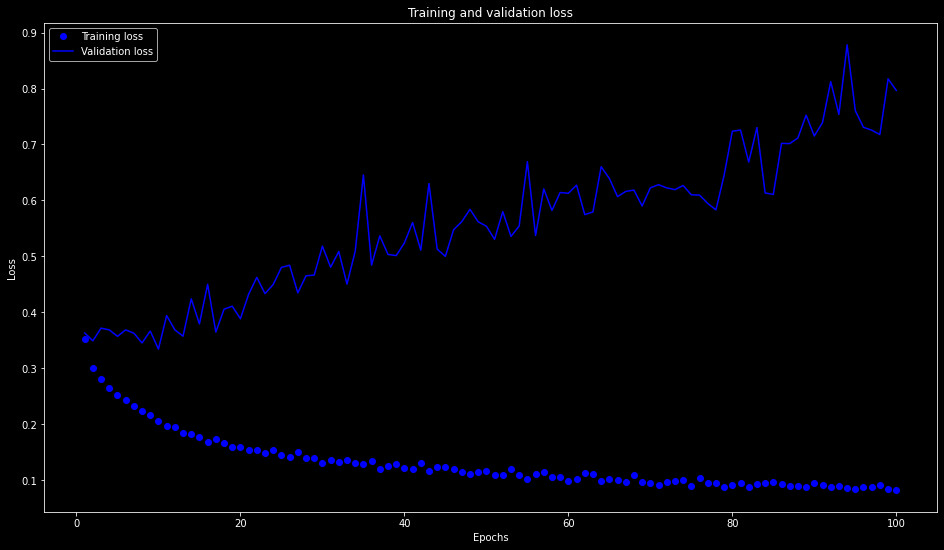

In [91]:
history_dict = history.history
history_dict.keys()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

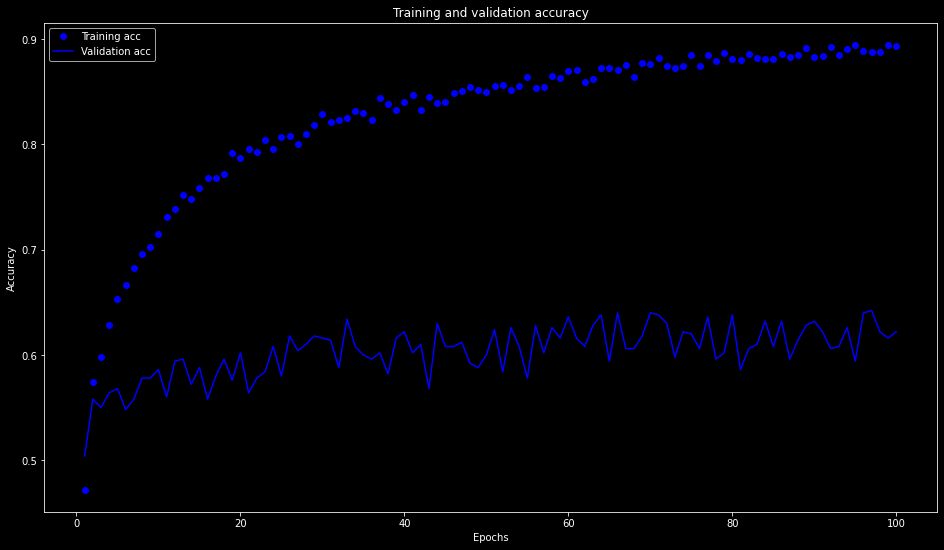

In [92]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

CNN уступает даже бейзлайну, видно переобучение, и почти горизонтальная линия на валидационной выборке

#### CNN tuning

In [112]:
inp = tf.keras.layers.Input( shape=(max_length,))
x = tf.keras.layers.Embedding(input_dim=vocab_size, 
                              output_dim=emdedding_size, 
                              input_length=max_length,
                              weights = [pretrained_weights],
                              trainable = False)(inp)

x = tf.keras.layers.Conv1D(128, 5, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
outp = tf.keras.layers.Dense(6, activation="softmax")(x) 

model = tf.keras.models.Model(inputs=inp, outputs=outp)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_x, train_y,
                    epochs=100,
                    validation_data=(test_x, test_y),
                    batch_size=10)

(None, 18, 300)
(None, 128)
(None, 64)
Epoch 1/100
546/546 [==============================] - 7s 12ms/step - loss: 0.3939 - accuracy: 0.3745 - val_loss: 0.3809 - val_accuracy: 0.5000
Epoch 2/100
546/546 [==============================] - 5s 10ms/step - loss: 0.3336 - accuracy: 0.5086 - val_loss: 0.4098 - val_accuracy: 0.5320
Epoch 3/100
546/546 [==============================] - 6s 10ms/step - loss: 0.3181 - accuracy: 0.5444 - val_loss: 0.3821 - val_accuracy: 0.5260
Epoch 4/100
546/546 [==============================] - 5s 10ms/step - loss: 0.3032 - accuracy: 0.5752 - val_loss: 0.3483 - val_accuracy: 0.5600
Epoch 5/100
546/546 [==============================] - 6s 10ms/step - loss: 0.2944 - accuracy: 0.5906 - val_loss: 0.3701 - val_accuracy: 0.5260
Epoch 6/100
546/546 [==============================] - 5s 10ms/step - loss: 0.2839 - accuracy: 0.6075 - val_loss: 0.3632 - val_accuracy: 0.5660
Epoch 7/100
546/546 [==============================] - 5s 10ms/step - loss: 0.2762 - accuracy: 0.

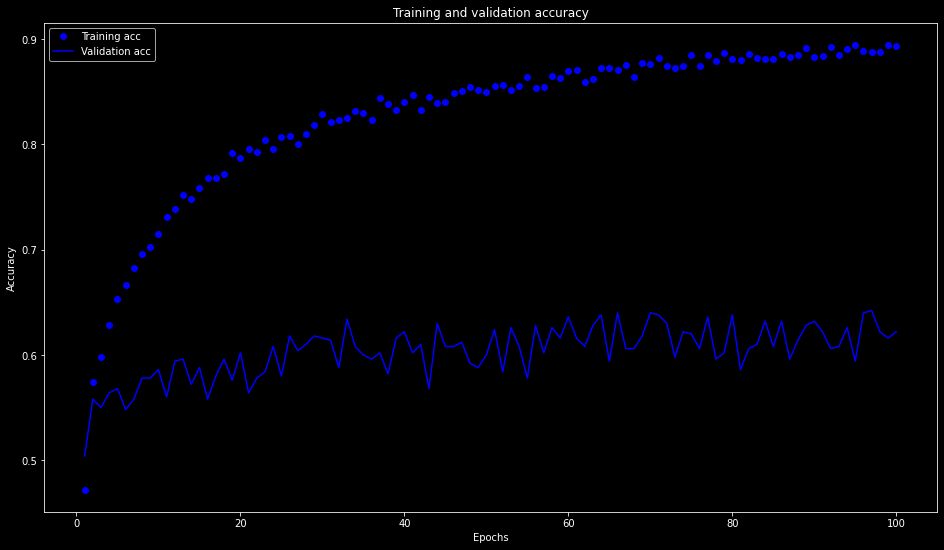

In [113]:
history_dict = history.history
history_dict.keys()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Добавление дропаутов не помогло

### LSTM


In [114]:
inp = tf.keras.layers.Input( shape=(max_length,))
x = tf.keras.layers.Embedding(input_dim=vocab_size, 
                              output_dim=emdedding_size, 
                              input_length=max_length,
                              weights = [pretrained_weights],
                              trainable = False)(inp)

x = tf.keras.layers.LSTM(128, dropout=0.1, recurrent_dropout=0.1)(x)
outp = tf.keras.layers.Dense(6, activation="softmax")(x) 

model = tf.keras.models.Model(inputs=inp, outputs=outp)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_x, train_y,
                    epochs=100,
                    validation_data=(test_x, test_y),
                    batch_size=10)

Epoch 1/100
546/546 [==============================] - 36s 61ms/step - loss: 0.4153 - accuracy: 0.2759 - val_loss: 0.3938 - val_accuracy: 0.4000
Epoch 2/100
546/546 [==============================] - 33s 61ms/step - loss: 0.3559 - accuracy: 0.4815 - val_loss: 0.3491 - val_accuracy: 0.5540
Epoch 3/100
546/546 [==============================] - 33s 61ms/step - loss: 0.3079 - accuracy: 0.5752 - val_loss: 0.3294 - val_accuracy: 0.6160
Epoch 4/100
546/546 [==============================] - 33s 60ms/step - loss: 0.2868 - accuracy: 0.6148 - val_loss: 0.3329 - val_accuracy: 0.5840
Epoch 5/100
546/546 [==============================] - 33s 60ms/step - loss: 0.2756 - accuracy: 0.6348 - val_loss: 0.3185 - val_accuracy: 0.5840
Epoch 6/100
546/546 [==============================] - 33s 61ms/step - loss: 0.2626 - accuracy: 0.6515 - val_loss: 0.3217 - val_accuracy: 0.5980
Epoch 7/100
546/546 [==============================] - 33s 61ms/step - loss: 0.2513 - accuracy: 0.6676 - val_loss: 0.3153 - val_ac

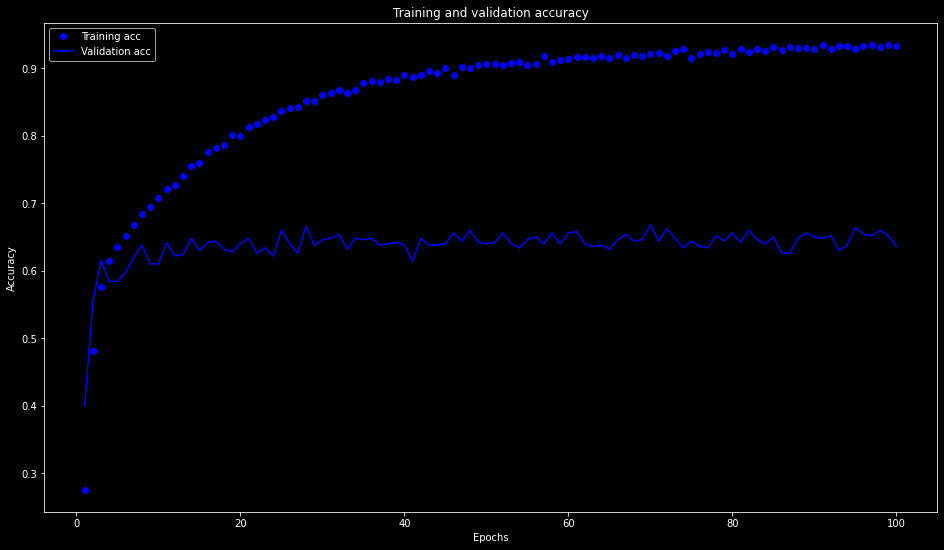

In [116]:
history_dict = history.history
history_dict.keys()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

ЛСТМ практически сразу вышла на линию для валидации, но осталась на уровне МЛП

### RNN LSTM


In [124]:
inp = tf.keras.layers.Input( shape=(max_length,))
x = tf.keras.layers.Embedding(input_dim=vocab_size, 
                              output_dim=emdedding_size, 
                              input_length=max_length,
                              weights = [pretrained_weights],
                              trainable = False, mask_zero=True)(inp)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
outp = tf.keras.layers.Dense(6, activation="softmax")(x) 

model = tf.keras.models.Model(inputs=inp, outputs=outp)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_x, train_y,
                    epochs=20,
                    validation_data=(test_x, test_y),
                    batch_size=10)

Epoch 1/20
546/546 [==============================] - 51s 64ms/step - loss: 0.3671 - accuracy: 0.4862 - val_loss: 0.3671 - val_accuracy: 0.5860
Epoch 2/20
546/546 [==============================] - 31s 56ms/step - loss: 0.3027 - accuracy: 0.5965 - val_loss: 0.3288 - val_accuracy: 0.6000
Epoch 3/20
546/546 [==============================] - 30s 55ms/step - loss: 0.2755 - accuracy: 0.6315 - val_loss: 0.3005 - val_accuracy: 0.6380
Epoch 4/20
546/546 [==============================] - 30s 55ms/step - loss: 0.2549 - accuracy: 0.6667 - val_loss: 0.2844 - val_accuracy: 0.6520
Epoch 5/20
546/546 [==============================] - 30s 55ms/step - loss: 0.2387 - accuracy: 0.6908 - val_loss: 0.2766 - val_accuracy: 0.6540
Epoch 6/20
546/546 [==============================] - 30s 55ms/step - loss: 0.2224 - accuracy: 0.7096 - val_loss: 0.2720 - val_accuracy: 0.6760
Epoch 7/20
546/546 [==============================] - 30s 56ms/step - loss: 0.2082 - accuracy: 0.7298 - val_loss: 0.2652 - val_accuracy:

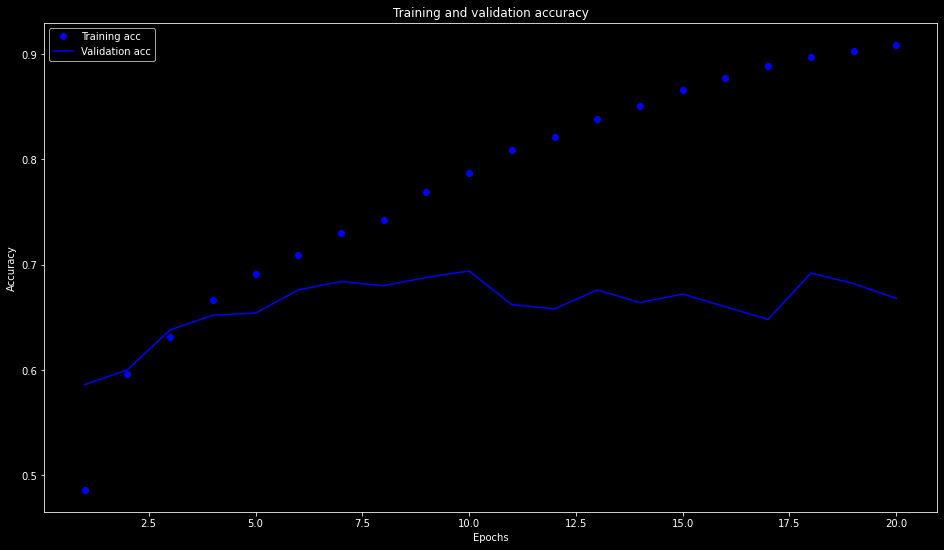

In [125]:
history_dict = history.history
history_dict.keys()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

RNN показала лучший результат среди нейронок, но видимо нужно получше поработать с датасетом, тк результаты все равно печальные

## Выводы

Все опробованные классификаторы показывают результаты не более чем 75проц, водимо, подход с word2vec не самый оптимальный для этого датасета, и нужно добавлять дополнительные фичи